<a href="https://colab.research.google.com/github/keval47/Machine-Learning/blob/master/ffnn_multi_class_stochastic_gradient_decent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

In [0]:
data = load_digits()
X = data.data
Y = data.target

scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state = 42)

y_train = y_train.reshape(len(y_train),1)
y_test = y_test.reshape(len(y_test),1)

In [0]:
class Neuron:
    def __init__(self,inputNeuron,hiddenNeuron,outputNeuron):
        self.w_ih = np.random.random((inputNeuron,hiddenNeuron)) # (2x3) weights b/w input and hidden layer         
        self.b_ih = np.random.random((1,hiddenNeuron)) #(1x3) bias b/w input and hidden layer

        self.w_ho = np.random.random((hiddenNeuron,outputNeuron)) # (3x1) weights b/w hidden and output layer
        self.b_ho = np.random.random((1,outputNeuron)) #(1x1) bias b/w  hidden and output layer

        self.hiddenLayerOutput = np.array((hiddenNeuron,1),dtype=np.float64) # (3x1) just for store output generated by model
        self.outputLayerOutput = np.array((outputNeuron,1),dtype=np.float64) # (1x1) just for store output generated by model

In [0]:
class ffnn:
    def __init__(self):
        pass

    def layers(self,inputNeuron,hiddenNeuron,outputNeuron):
        self._neuron = Neuron(inputNeuron,hiddenNeuron,outputNeuron)# creating neurons

    # function for matrix multiplication you can also use np.dot
    def _dot(self,a,b):
        matmul = []
        for val in a:
            valSum = 0
            for i in range(len(val)):
                valSum += val[i] * b[i]
            matmul.append(valSum)
        return np.array(matmul)

    def _OneHotEncoder(self,x):
        arr = np.zeros((len(x),np.max(x)+1),dtype=int)
        for i,val in enumerate(x):
            arr[i][val[0]] = 1
        return arr

    def _relu(self,z,deriv=False):
        if(deriv):
            return (z > 0) * 1.0
        return np.maximum(0,z)

    def _sigmoid(self,z,deriv=False):
        if(deriv):
            return z * (1-z)
        return 1/(1+(np.exp(-z)))
    
    def _softmax(self,x):
        xrel = x - x.max(axis=1, keepdims=True)# make every value 0 or below, as exp(0) won't overflow
        exp_xrel = np.exp(xrel)
        return exp_xrel / exp_xrel.sum(axis=1, keepdims=True) 
    
    # return weighted sum. return output based on weights
    def _feedforward(self):
        self._neuron.hiddenLayerOutput = self._relu(self._dot(self._x,self._neuron.w_ih)+self._neuron.b_ih)
        self._neuron.outputLayerOutput = self._softmax(self._dot(self._neuron.hiddenLayerOutput,self._neuron.w_ho)+self._neuron.b_ho)

    # perform backpropagation. adjusts weights that let us close to accurate output 
    def _backProp(self):
        err_ho = self._y - self._neuron.outputLayerOutput #calculate gradient of err. gradient=direction
        slope_ho = self._relu(self._neuron.outputLayerOutput,True) # calculate slope of output
        delta_ho = err_ho * slope_ho #change in w_ho weights. define direction that make less error

        err_ih = self._dot(delta_ho,self._neuron.w_ho.T)  # define gradient of err based on output layer error
        slope_ih = self._relu(self._neuron.hiddenLayerOutput,True) #calculate slope of hidden layer output
        delta_ih = err_ih * slope_ih #change in i_ho weights. define direction that make less error
        
        # adjust weights to make less err
        self._neuron.w_ih += self._dot(self._x.T,delta_ih) * self._lr #step further to defined direction by delta.step = learning rate
        self._neuron.w_ho += self._dot(self._neuron.hiddenLayerOutput.T,delta_ho) * self._lr #step further to defined direction by delta. step = learning rate

         # adjust bias to make less err
        self._neuron.b_ih += np.sum(delta_ih,axis=0) * self._lr #step further to defined direction by delta. step = learning rate
        self._neuron.b_ho += np.sum(delta_ho,axis=0) * self._lr #step further to defined direction by delta. step = learning rate

    def _err(self):
        # mean squared err
        err = np.mean(np.square(self._y - self._neuron.outputLayerOutput),dtype=np.float64)
        return err

    def predict(self,x,prob=False):
        if(prob):
            res = np.zeros((np.shape(x)[0],np.shape(x)[1]))
        else:
            res = np.zeros((np.shape(x)[0],1),dtype=int)

        for i,val in enumerate(x):
            ho = self._relu(self._dot([val],self._neuron.w_ih)+self._neuron.b_ih)
            output = self._softmax(self._dot(ho,self._neuron.w_ho)+self._neuron.b_ho)
            if(prob):
                res[i] = output
            else:
                res[i]= np.argmax(output)
        return res

    def hyper_params(self,lr=0.5,epochs=20,batch_size=32):
        self._lr = lr # learning rate
        self._epochs = epochs #iteration how many times data will be train
        self._batchSize = batch_size

    def fit(self,X,Y):
        self._x = X
        self._y = self._OneHotEncoder(Y)

    def _makeBatches(self):
        x = self._x
        y = self._y
        b = self._batchSize
        n_batchesDiv = int(x.shape[0] / b)
        batches = []
        for r in range(0,n_batchesDiv):
            # r = np.random.randint(0,n_batchesDiv)
            X = x[ (r*b) : ((r+1)*b) ]
            Y = y[ (r*b) : ((r+1)*b) ]
            batches.append([X,Y])
        return batches

    def train(self,printErr=False):
        batches = self._makeBatches()
        err = np.zeros((self._epochs,len(batches)))
        for i in range(self._epochs):
            for j,batch in enumerate(batches):
                self._x,self._y = batch
                self._feedforward()
                self._backProp()
                err[i][j] = self._err()
            if(printErr):
                print("epoch =",i+1,"|| err =",self._err())
            else:
                print("\r Epoch->",i+1,end="")
        return err

In [180]:
# running model
il = X_train.shape[1]
neuralnet = ffnn()
neuralnet.hyper_params(lr=0.01,epochs=20 ,batch_size=1)
neuralnet.layers(il,32,10)
neuralnet.fit(X_train,y_train)
err = neuralnet.train(True)

epoch = 1 || err = 0.07915005696715402
epoch = 2 || err = 0.015803293631422535
epoch = 3 || err = 0.009797887986546155
epoch = 4 || err = 0.021194305641796522
epoch = 5 || err = 0.03407516058628384
epoch = 6 || err = 0.002996382463347216
epoch = 7 || err = 0.0024056743584266733
epoch = 8 || err = 0.0022596206568358933
epoch = 9 || err = 0.0023567640843167236
epoch = 10 || err = 0.0022095206248134744
epoch = 11 || err = 0.002021785683850094
epoch = 12 || err = 0.0017640879741634518
epoch = 13 || err = 0.0014898887138509096
epoch = 14 || err = 0.001340945416961365
epoch = 15 || err = 0.0012309553824492985
epoch = 16 || err = 0.0010471732871765054
epoch = 17 || err = 0.000879135971837333
epoch = 18 || err = 0.0008297926462616163
epoch = 19 || err = 0.0007277319154004085
epoch = 20 || err = 0.0006286662571280326


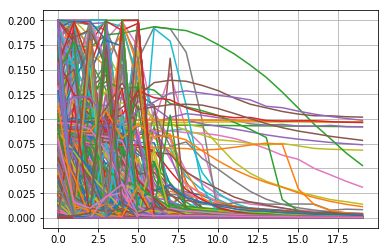

In [181]:
plt.plot(err)
plt.grid()
plt.show()

In [182]:
predictTrain = neuralnet.predict(X_train)
predictsTest = neuralnet.predict(X_test)
print("training acc = ",accuracy_score(y_train,predictTrain))
print("testing acc = ",accuracy_score(y_test,predictsTest))

training acc =  0.9925760950259837
testing acc =  0.9466666666666667


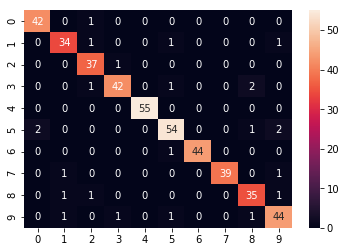

In [183]:
heatmap(confusion_matrix(y_test,predictsTest),annot=True)

In [0]:
def OneHotEncoder(x):
    arr = np.zeros((len(x),np.max(x)+1),dtype=int)
    for i,val in enumerate(x):
        arr[i][val[0]] = 1
    return arr

In [122]:
# implimenting using keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=64))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.1)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, OneHotEncoder(y_train),
          epochs=20,
          batch_size=1)
score = model.evaluate(X_test, OneHotEncoder(y_test), batch_size=1)

Epoch 1/20
1347/1347 [==============================] - 2s 2ms/step - loss: 0.0280 - acc: 0.8107
Epoch 2/20
1347/1347 [==============================] - 1s 1ms/step - loss: 0.0065 - acc: 0.9666
Epoch 3/20
1347/1347 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.9822
Epoch 4/20
1347/1347 [==============================] - 2s 1ms/step - loss: 0.0017 - acc: 0.9926
Epoch 5/20
1347/1347 [==============================] - 2s 1ms/step - loss: 0.0012 - acc: 0.9941
Epoch 6/20
1347/1347 [==============================] - 2s 1ms/step - loss: 8.3480e-04 - acc: 0.9955
Epoch 7/20
1347/1347 [==============================] - 2s 1ms/step - loss: 9.9406e-04 - acc: 0.9941
Epoch 8/20
1347/1347 [==============================] - 2s 1ms/step - loss: 6.0780e-04 - acc: 0.9978
Epoch 9/20
1347/1347 [==============================] - 1s 1ms/step - loss: 3.5329e-04 - acc: 0.9985
Epoch 10/20
1347/1347 [==============================] - 1s 1ms/step - loss: 3.3826e-04 - acc: 0.9985
Epoch 11/

In [123]:
mp = model.predict_classes(X_test)
accuracy_score(y_test,mp)

0.9777777777777777

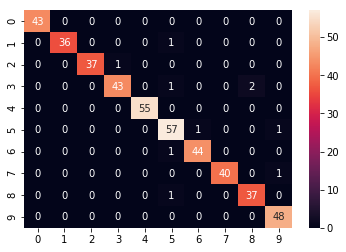

In [124]:
heatmap(confusion_matrix(y_test,mp),annot=True)